```
Regression Modeling in Practice Course
Wesleyan University

Linear Regression Model
Mario Colosso V.

The sample comes from Cortez and Morais study about predicting forest fires using 
metereological data [Cortez and Morais, 2007]. The study includes data from 517
forest fires in the Natural Park Montesinho (Trás-os -Montes, in northeastern Portugal)
January 2000 to December 2003, including meteorological data, the type of vegetation
involved (which determines the six components of the Canadian Forest Fire Weather Index
(FWI) system --see below--) and the total burned area in order to generate a model capable
of predicting the burned area of small fires, which are more frequent.

Measures
The data contains:
* X, Y: location of the fire (x,y axis spatial coordinate within the Montesinho park map:
  from 1 to 9)
* month, day: month and day of the week the fire occurred (january to december and monday
  to sunday)
* FWI system components:
  - FFMC: Fine Fuel Moisture Code (numeric rating of the moisture content of litter and
    other cured fine fuels: 18.7 to 96.2)
  - DMC: Duff Moisture Code (numeric rating of the average moisture content of loosely
    compacted organic layers of moderate depth: 1.1 to 291.3)
  - DC: Drought Code (numeric rating of the average moisture content of deep, compact
    organic layers: 7.9 to 860.6)
  - ISI: Initial Spread Index (numeric rating of the expected rate of fire spread: 0.0
    to 56.1)
* Metereological variables:
  - temp: temperature (2.2 to 33.3 °C)
  - RH: relative humidity (15 to 100%)
  - wind: wind speed (0.4 to 9.4 Km/h)
  - rain: outside rain (0.0 to 6.4 mm/m^2)
* area: the burned area of the forest as response variable (0.0 to 1090.84 Ha).

```

In [1]:
%matplotlib inline

import pandas
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from math import ceil

pandas.set_option('display.float_format', lambda x:'%.3f'%x)
plt.style.use('ggplot') # Make the graphs a bit prettier
plt.rcParams['figure.figsize'] = (15, 5)

### Load Forest Fires .csv file

In [2]:
fires = pandas.read_csv('forestfires.csv')

## 1. Lets have a brief look of Fires DataFrame

In [3]:
fires.head()   #Show first rows

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.200,26.200,94.300,5.100,8.200,51,6.700,0.000,0.000
1,7,4,oct,tue,90.600,35.400,669.100,6.700,18.000,33,0.900,0.000,0.000
2,7,4,oct,sat,90.600,43.700,686.900,6.700,14.600,33,1.300,0.000,0.000
3,8,6,mar,fri,91.700,33.300,77.500,9.000,8.300,97,4.000,0.200,0.000
4,8,6,mar,sun,89.300,51.300,102.200,9.600,11.400,99,1.800,0.000,0.000


### Get some descriptive statistic of the data

In [4]:
fires_attributes = fires.columns.values.tolist()
number_of_columns = len(fires_attributes)

In [5]:
statistics = pandas.DataFrame(index=range(0, number_of_columns - 2), 
                              columns=('min', 'max', 'mean', 'median', 'std'))

In [6]:
idx = 0
for attr in [0, 1] + list(range(4, number_of_columns)):
    statistics.loc[idx] = {'min':    min(fires[fires_attributes[attr]]), 
                           'max':    max(fires[fires_attributes[attr]]),
                           'mean':   fires[fires_attributes[attr]].mean(),
                           'median': fires[fires_attributes[attr]].median(),
                           'std':    fires[fires_attributes[attr]].std()}
    idx += 1
statistics.index = [fires_attributes[attr] 
                    for attr in [0, 1] + list(range(4, number_of_columns))]

In [7]:
statistics.T   #Show min, max, mean, median and standard deviation

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
min,1.000,2.000,18.700,1.100,7.900,0.000,2.200,15.000,0.400,0.000,0.000
max,9.000,9.000,96.200,291.300,860.600,56.100,33.300,100.000,9.400,6.400,1090.840
mean,4.669,4.300,90.645,110.872,547.940,9.022,18.889,44.288,4.018,0.022,12.847
median,4.000,4.000,91.600,108.300,664.200,8.400,19.300,42.000,4.000,0.000,0.520
std,2.314,1.230,5.520,64.046,248.066,4.559,5.807,16.317,1.792,0.296,63.656


### And display a graph of quantitative variables vs area

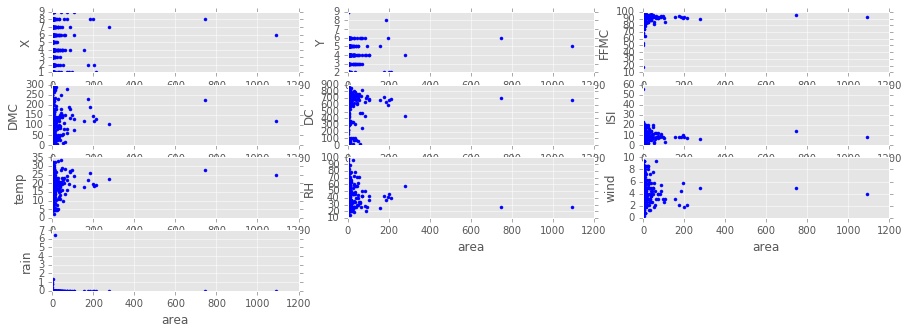

In [8]:
attributes = [0, 1] + list(range(4, number_of_columns - 1))
n_cols = 3
n_rows = int(ceil(len(attributes) / n_cols))
fig = plt.figure()
idx = 1
for attr in attributes:
    plt.subplot(n_rows, n_cols, idx)
    plt.plot(fires['area'], fires[fires_attributes[attr]], 'b.')
    plt.xlabel('area')
    plt.ylabel(fires_attributes[attr])
    idx += 1

plt.show()

#### There are some data values where the burned area is away from other values

In [9]:
fires[fires['area'] > 250]

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
238,6,5,sep,sat,92.500,121.100,674.400,8.600,25.100,27,4.000,0.000,1090.840
415,8,6,aug,thu,94.800,222.400,698.600,13.900,27.500,27,4.900,0.000,746.280
479,7,4,jul,mon,89.200,103.900,431.600,6.400,22.600,57,4.900,0.000,278.530


### Plot some other variables

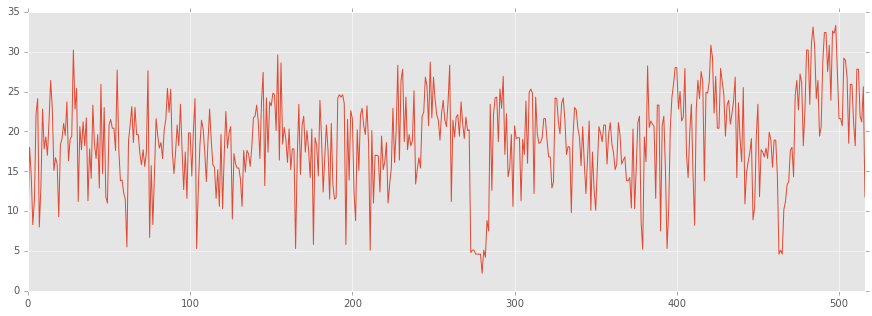

In [10]:
fires['temp'].plot()   #Plot temperature graph

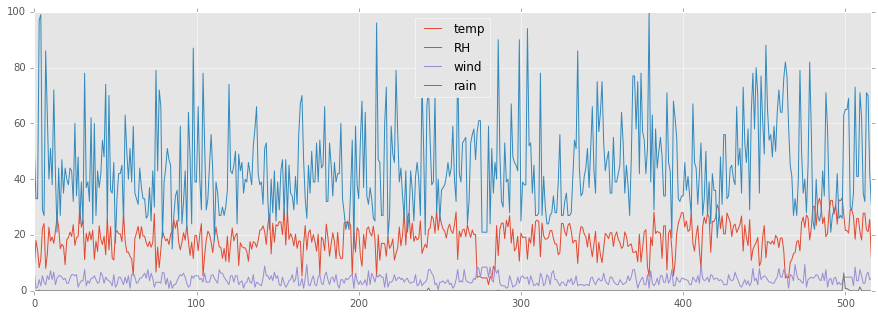

In [11]:
fires[['temp', 'RH', 'wind', 'rain']].plot()   #Plot temperature, relative humidity, wind 
                                               #and rain graphs

In [12]:
fires.corr()   #Show correlation between variables

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
X,1.000,0.540,-0.021,-0.048,-0.086,0.006,-0.051,0.085,0.019,0.065,0.063
Y,0.540,1.000,-0.046,0.008,-0.101,-0.024,-0.024,0.062,-0.020,0.033,0.045
FFMC,-0.021,-0.046,1.000,0.383,0.331,0.532,0.432,-0.301,-0.028,0.057,0.040
DMC,-0.048,0.008,0.383,1.000,0.682,0.305,0.470,0.074,-0.105,0.075,0.073
DC,-0.086,-0.101,0.331,0.682,1.000,0.229,0.496,-0.039,-0.203,0.036,0.049
ISI,0.006,-0.024,0.532,0.305,0.229,1.000,0.394,-0.133,0.107,0.068,0.008
temp,-0.051,-0.024,0.432,0.470,0.496,0.394,1.000,-0.527,-0.227,0.069,0.098
RH,0.085,0.062,-0.301,0.074,-0.039,-0.133,-0.527,1.000,0.069,0.100,-0.076
wind,0.019,-0.020,-0.028,-0.105,-0.203,0.107,-0.227,0.069,1.000,0.061,0.012
rain,0.065,0.033,0.057,0.075,0.036,0.068,0.069,0.100,0.061,1.000,-0.007


## 2. Linear regression

### Convert categorical variables (months and days) into numerical values

In [13]:
months_table = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 
                'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
days_table =   ['sun', 'mon', 'tue', 'wed', 'thu', 'fri', 'sat']

fires['month'] = [months_table.index(month) for month in fires['month'] ]
fires['day'] =   [days_table.index(day)     for day   in fires['day']   ]

fires['X'] -= 1
fires['Y'] -= 2

fires.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,6,3,2,5,86.200,26.200,94.300,5.100,8.200,51,6.700,0.000,0.000
1,6,2,9,2,90.600,35.400,669.100,6.700,18.000,33,0.900,0.000,0.000
2,6,2,9,6,90.600,43.700,686.900,6.700,14.600,33,1.300,0.000,0.000
3,7,4,2,5,91.700,33.300,77.500,9.000,8.300,97,4.000,0.200,0.000
4,7,4,2,0,89.300,51.300,102.200,9.600,11.400,99,1.800,0.000,0.000


### Center each explanatory variable

In [14]:
for idx in list(range(4, number_of_columns - 1)):   #Exclude categorical variables
    fires[fires_attributes[idx]] = fires[fires_attributes[idx]] - \
                                   fires[fires_attributes[idx]].mean()

In [15]:
statistics = [fires[fires_attributes[idx]].mean() for idx in range(0, number_of_columns)]
statistics = pandas.DataFrame(statistics, 
                              index=fires_attributes,
                              columns=['mean'])

In [16]:
statistics.T   #Only quantitative explanatory variables (FFMC thru rain) were centered

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
mean,3.669,2.300,6.476,2.973,0.000,-0.000,0.000,-0.000,0.000,0.000,-0.000,0.000,12.847


### Generate models to test each variable

In [17]:
statistics = list()
for idx in range(0, number_of_columns - 1):
    model = smf.ols(formula = "area ~ " + 
                    fires_attributes[idx], data = fires).fit()
    
    title = 'Model: area ~ ' + fires_attributes[idx]
    print('+' + "-" * (len(title) + 2) + '+' + '\n' + 
          '| ' + title + ' |' + '\n' + 
          '+' + "-" * (len(title) + 2) + '+')
    print()
    print(model.summary())
    print()
    statistics.append([model.f_pvalue, model.rsquared])

+-----------------+
| Model: area ~ X |
+-----------------+

                            OLS Regression Results                            
Dep. Variable:                   area   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     2.077
Date:                Sat, 11 Jun 2016   Prob (F-statistic):              0.150
Time:                        18:12:03   Log-Likelihood:                -2879.4
No. Observations:                 517   AIC:                             5763.
Df Residuals:                     515   BIC:                             5771.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------

### Models summary:

In [18]:
statistics = pandas.DataFrame(statistics, 
                              index=fires_attributes[: number_of_columns - 1], 
                              columns=['p-value', 'R-squared'])
statistics.T

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain
p-value,0.150,0.309,0.200,0.272,0.363,0.097,0.262,0.851,0.026,0.086,0.780,0.867
R-squared,0.004,0.002,0.003,0.002,0.002,0.005,0.002,0.000,0.010,0.006,0.000,0.000


In [19]:
statistics[statistics['p-value'] < 0.05]

,p-value,R-squared
temp,0.026,0.010


'temp' is the only statistically significant variable (p-value = 0.026) but it only explains the 1% of forest fires. Let's show its linear model summary:

In [20]:
print((smf.ols(formula = "area ~ temp", data = fires).fit()).summary())

                            OLS Regression Results                            
Dep. Variable:                   area   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     4.978
Date:                Sat, 11 Jun 2016   Prob (F-statistic):             0.0261
Time:                        18:12:04   Log-Likelihood:                -2878.0
No. Observations:                 517   AIC:                             5760.
Df Residuals:                     515   BIC:                             5768.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     12.8473      2.789      4.607      0.0

**The results of the linear regression models indicated than only temperature (Beta = 1.0726, p = 0.026, $R^2$ = 0.010) was significantly and positively associated with the total burned area due to forest fires. _'p-value'_ of other models are greater than treshold value of 0.05 so results are not statistically significant to reject null hypothesis.**

### Create a Linear Regression Model for a combination of all variables

In [21]:
explanatory_variables = "X + Y + month + day + FFMC + DMC + DC + ISI + temp + RH + " + \
                        "wind + rain"
response_variable =     "area"

model = smf.ols(formula = response_variable + " ~ " + explanatory_variables, 
                data = fires).fit()

In [22]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   area   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.092
Date:                Sat, 11 Jun 2016   Prob (F-statistic):              0.364
Time:                        18:12:04   Log-Likelihood:                -2873.8
No. Observations:                 517   AIC:                             5774.
Df Residuals:                     504   BIC:                             5829.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    -17.5974     19.340     -0.910      0.3

**_p-value_ of combination model (p = 0.410) is bigger than treshold value, so the combination of the Canadian Forest Fire Weather Index (FWI) system plus temperature, humidity, wind and rain are not significantly associated with the total burned area due to forest fires. _p-value_ of temperature in combination model (p = 0.282) is not longer statistically significant, a confounder variable?**

Also, there is a warning in previous model summary: _"The condition number is large, 1.76e+03. This might indicate that there are ***strong multicollinearity*** or other numerical problems."_   We will review this issue next week.